<a href="https://colab.research.google.com/github/rtajeong/Kyungnam_univ_M4/blob/main/lab_07_simple_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Before we go for M-4 labs
- from "모두의 딥러닝"

## 12. multinomial classification
- iris data
- one-hot encoding
- softmax
- F-fold cross validation

In [1]:
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
np.random.seed(17)
iris_data = sns.load_dataset("iris")
iris_data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
dataset = iris_data.values
X = dataset[:,0:4].astype('float')
Y_obj = dataset[:,4]

Y = LabelEncoder().fit_transform(Y_obj)
Y_encoded = np_utils.to_categorical(Y)   #  one-hot encoding

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_encoded, test_size=0.2)

In [5]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((120, 4), (120, 3), (30, 4), (30, 3))

In [6]:
# model and compile & train & predict(evaluate)
model = Sequential()
# model.add(Dense(16,  input_dim=4, activation='relu'))
model.add(Dense(16,  input_shape=(4,), activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=100, 
                    batch_size=5, verbose=0)
model.save('iris_model.h5')

In [8]:
from keras.models import load_model
del model   # delete existing models in memory
model = load_model('iris_model.h5')  # newly call the model
print("\n Accuracy: %.4f" % (model.evaluate(X_test, Y_test)[1]))

1/1 [==============================] - 0s 109ms/step - loss: 0.1729 - accuracy: 0.9667

 Accuracy: 0.9667


In [9]:
X.shape, Y.shape

((150, 4), (150,))

In [10]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

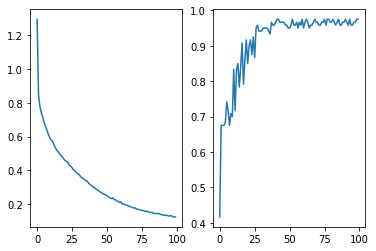

In [11]:
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])

In [13]:
model.evaluate(X_test, Y_test)

1/1 [==============================] - 0s 16ms/step - loss: 0.1729 - accuracy: 0.9667


[0.17288468778133392, 0.9666666388511658]

In [23]:
Y_pred = model.predict(X_test)
tf.math.confusion_matrix(Y_test.argmax(1), Y_pred.argmax(1))

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[ 7,  0,  0],
       [ 0, 11,  0],
       [ 0,  1, 11]], dtype=int32)>

## for K-fold validation

In [25]:
X.shape, Y.shape

((150, 4), (150,))

In [27]:
from sklearn.model_selection import StratifiedKFold

n_fold = 5
skf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=17)

cvscores = []
for train_index, test_index in skf.split(X, Y):
    model = Sequential()
    model.add(Dense(16,  input_dim=4, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    y_train_enc = np_utils.to_categorical(y_train)
    y_test_enc = np_utils.to_categorical(y_test)
    
    model.fit(X_train, y_train_enc, epochs=30, batch_size=5, verbose=0)
    score = model.evaluate(X_test, y_test_enc, verbose=0)
    cvscores.append(score)

In [28]:
model.metrics_names, cvscores

(['loss', 'accuracy'],
 [[0.4304458498954773, 0.9666666388511658],
  [0.4269561171531677, 0.9333333373069763],
  [0.36101362109184265, 0.9666666388511658],
  [0.33310678601264954, 0.9666666388511658],
  [0.24185629189014435, 1.0]])

## 14. Callback - check point and early stopping

In [29]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

import pandas as pd
import numpy as np
import os
import tensorflow as tf

- download wine.csv from https://codedragon.tistory.com/9480
  - class 1: red wine, 0: white wine

In [30]:
df_all = pd.read_csv('wine.csv', header=None)
df = df_all.sample(frac=0.2)  # get only 20% of dataset
df.shape

(1299, 13)

In [31]:
df.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12
3896,6.5,0.29,0.42,10.6,0.042,66.0,202.0,0.99674,3.24,0.53,9.5,6,0


In [32]:
df[12].value_counts()

0    984
1    315
Name: 12, dtype: int64

In [34]:
dataset = df.values
X, y = dataset[:,0:12], dataset[:,12]

model = Sequential()
model.add(Dense(30,  input_dim=12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])

# 모델 저장 폴더 만들기
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath="./model/{epoch:02d}-{val_loss:.4f}.hdf5"

# 모델 업데이트 및 저장 (epoch 마다)
checkpointer = ModelCheckpoint(filepath=modelpath, 
                               monitor='val_loss', 
                               verbose=1, 
                               save_best_only=True)  # record only when imrpoved

# 테스트 오차가 줄지 않으면 학습 자동 중단 설정 (모니터할 값 저장)
early_stopping_callback = EarlyStopping(monitor='val_loss', 
                                        patience=100) # 좋아지지 않아도 몇 번까지 기다릴것인지

In [ ]:
y_loss, y_acc, y_vloss, y_vacc = [], [], [], []

history = model.fit(X, y, validation_split=0.2, 
                    epochs=2000, batch_size=100, verbose=0, 
                    callbacks=[early_stopping_callback,checkpointer])
y_loss = history.history['loss']
y_acc = history.history['accuracy']
y_vloss = history.history['val_loss']
y_vacc = history.history['val_accuracy']
x_len = np.arange(len(y_acc))
plt.ylim(0.,1.)
plt.title("Traing")
plt.plot(x_len, y_loss, "o", c="r", markersize=3)
plt.plot(x_len, y_acc, "o", c="b", markersize=3)
plt.show()
plt.title("Validation")
plt.ylim(0.,1.)
plt.plot(x_len, y_vloss, "o", c="r", markersize=3)
plt.plot(x_len, y_vacc, "o", c="b", markersize=3)
plt.show()

In [38]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [39]:
print("Acuracy: %.4f" %(model.evaluate(X, y)[1]))

41/41 [==============================] - 0s 2ms/step - loss: 0.0293 - accuracy: 0.9892
Acuracy: 0.9892


- 2000 epoch 전에 중간에 중단됨을 알 수 있다.

## 15. Linear Regression
- boston area house price estimates

In [40]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split

import numpy
import pandas as pd
import tensorflow as tf

In [41]:
from sklearn.datasets import load_boston
house = load_boston()
X, y = house.data, house.target

In [42]:
X.shape, y.shape

((506, 13), (506,))

In [43]:
X[:5], y[:5]

(array([[6.3200e-03, 1.8000e+01, 2.3100e+00, 0.0000e+00, 5.3800e-01,
         6.5750e+00, 6.5200e+01, 4.0900e+00, 1.0000e+00, 2.9600e+02,
         1.5300e+01, 3.9690e+02, 4.9800e+00],
        [2.7310e-02, 0.0000e+00, 7.0700e+00, 0.0000e+00, 4.6900e-01,
         6.4210e+00, 7.8900e+01, 4.9671e+00, 2.0000e+00, 2.4200e+02,
         1.7800e+01, 3.9690e+02, 9.1400e+00],
        [2.7290e-02, 0.0000e+00, 7.0700e+00, 0.0000e+00, 4.6900e-01,
         7.1850e+00, 6.1100e+01, 4.9671e+00, 2.0000e+00, 2.4200e+02,
         1.7800e+01, 3.9283e+02, 4.0300e+00],
        [3.2370e-02, 0.0000e+00, 2.1800e+00, 0.0000e+00, 4.5800e-01,
         6.9980e+00, 4.5800e+01, 6.0622e+00, 3.0000e+00, 2.2200e+02,
         1.8700e+01, 3.9463e+02, 2.9400e+00],
        [6.9050e-02, 0.0000e+00, 2.1800e+00, 0.0000e+00, 4.5800e-01,
         7.1470e+00, 5.4200e+01, 6.0622e+00, 3.0000e+00, 2.2200e+02,
         1.8700e+01, 3.9690e+02, 5.3300e+00]]),
 array([24. , 21.6, 34.7, 33.4, 36.2]))

In [44]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = Sequential()
model.add(Dense(30, input_dim=13, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(1))    # no need of activation function
model.summary()
model.compile(loss='mse',
              optimizer='adam')

history = model.fit(X_train, y_train, epochs=200, batch_size=10, verbose=0)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 30)                420       
_________________________________________________________________
dense_43 (Dense)             (None, 6)                 186       
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 7         
Total params: 613
Trainable params: 613
Non-trainable params: 0
_________________________________________________________________


In [84]:
history.history.keys()

dict_keys(['loss'])

In [85]:
model.predict(X_test)[:5], model.predict(X_test)[:5].flatten()

(array([[11.71818 ],
        [18.97414 ],
        [28.645386],
        [24.603174],
        [12.326309]], dtype=float32),
 array([11.71818 , 18.97414 , 28.645386, 24.603174, 12.326309],
       dtype=float32))

In [86]:
# just for checking
model.predict(X_test)[:5][:,0] == model.predict(X_test)[:5].flatten()

array([ True,  True,  True,  True,  True])

In [87]:
# 예측 값과 실제 값의 비교
y_pred = model.predict(X_test).flatten()
for i in range(10):
    label = y_test[i]
    prediction = y_pred[i]
    print("real price: {:.3f}, predicted price: {:.3f}".format(label, prediction))

real price: 15.400, predicted price: 11.718
real price: 10.200, predicted price: 18.974
real price: 23.300, predicted price: 28.645
real price: 20.600, predicted price: 24.603
real price: 10.900, predicted price: 12.326
real price: 12.700, predicted price: 13.781
real price: 27.500, predicted price: 30.088
real price: 23.100, predicted price: 22.061
real price: 33.200, predicted price: 35.959
real price: 34.600, predicted price: 38.087


In [88]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 2ms/step - loss: 12.3138


12.313776969909668

In [92]:
from sklearn.metrics import r2_score
print(r2_score(y_test, model.predict(X_test)))
print(tf.metrics.mean_squared_error(y_test, model.predict(X_test))[0])

0.8816585327486025
tf.Tensor(224.37894, shape=(), dtype=float32)


In [90]:
y_test.shape, model.predict(X_test).shape

((152,), (152, 1))

# Exercise (연습)

In [99]:
# tf.function: Compiles a function into a callable TensorFlow graph.
#               (must be faster), but not always...?
import timeit
@tf.function
def dense_layer1(x, w, b):
    return tf.add(tf.matmul(x, w), b)

%time dense_layer1(tf.ones([3, 2]), tf.ones([2, 2]), tf.ones([2]))

CPU times: user 35.5 ms, sys: 723 µs, total: 36.2 ms
Wall time: 39.5 ms


<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[3., 3.],
       [3., 3.],
       [3., 3.]], dtype=float32)>

In [98]:
def dense_layer2(x, w, b):
    return tf.add(tf.matmul(x, w), b)
    
%time dense_layer2(tf.ones([3, 2]), tf.ones([2, 2]), tf.ones([2]))

CPU times: user 0 ns, sys: 1.78 ms, total: 1.78 ms
Wall time: 1.24 ms


<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[3., 3.],
       [3., 3.],
       [3., 3.]], dtype=float32)>

In [97]:
import timeit
conv_layer = tf.keras.layers.Conv2D(100, 3)

@tf.function
def conv_fn(image):
  return conv_layer(image)

image = tf.zeros([1, 200, 200, 100])
# 워밍 업
conv_layer(image); conv_fn(image)
print("즉시 실행 합성곱:", timeit.timeit(lambda: conv_layer(image), number=10))
print("tf.function 합성곱:", timeit.timeit(lambda: conv_fn(image), number=10))
print("합성곱 연산 속도에 큰 차이가 없습니다.")

즉시 실행 합성곱: 0.002809227999932773
tf.function 합성곱: 0.0038376010002139083
합성곱 연산 속도에 큰 차이가 없습니다.
